# Augmenting the EEG data around braking event  

The fisrt idea to use KL decomposition was to build a good approximation that could recreate the data and so have a model to AUGMENT THE DATA.

This notebook is used to understand the KL notation and utilities.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd 

In [13]:
# DO not run
import os
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/Only_events'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))

df_eeg_events = pd.DataFrame([])
eeg_events_index = []
for num, file in enumerate(files): # create a pandas df with 
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    outliers = np.unique(np.where(np.asarray(df_interval)>2000)[0])
    if len(outliers) == 0:
        df_eeg_events = df_eeg_events.append(df_interval)
        eeg_events_index = np.append(eeg_events_index, int(num))
df_eeg_events.to_csv(r'df_eeg_only_events.csv', index = False)
print(df_eeg_events.shape)

(13216, 320)


## <font color='blue'> Import learning data </font>

In [2]:
test_id = "VPja.mat" # Not used here
df_eeg_event_file = 'df_eeg_only_events.csv' # Corresponds to VPja
#Lecture
df_eeg_events = pd.read_csv( df_eeg_event_file )
n_channels = 59
split   = df_eeg_events.shape[1] 
nSample = df_eeg_events.shape[0]
#Traitement  
NPeeg = np.asarray(df_eeg_events)
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
mu_t    = NPeegC.mean(axis=0) # Pour avoir des processus centrés

In [3]:
NPeegC.shape

(13216, 320)

##  <font color='blue'>FPCA </font>

In [1]:
# OpenTurns:
import openturns as ot
dim_ch = 1
step_ms = 1 # 5 for 5ms as in data 
time_grid      = ot.RegularGrid(0, step_ms, split) # RegularGrid(start, step, n)
# A ProcessSample stores a sample of fields. 
#process_sample = ot.ProcessSample(time_grid, nSample-1, dim_ch)  #le 1 correspond a la dimension du champ en entrée
process_sample = ot.ProcessSample(time_grid, nSample, dim_ch) 
# mesh: The mesh shared by all the fields in the collection.
# K: Number of fields in the collection.
#d: Dimension of the values of the field.
field          = ot.Field(time_grid, dim_ch)                     #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    field.setValues(NPeegC[k:k+dim_ch,:].T - mu_t.reshape(-1,1))
    process_sample[k] = field

NameError: name 'split' is not defined

In [5]:
len(process_sample)

13216

/Users/obando_c/anaconda3/envs/advisedlib-env/lib/python3.7/site-packages/openturns/viewer.py:559: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._fig.show(**kwargs)


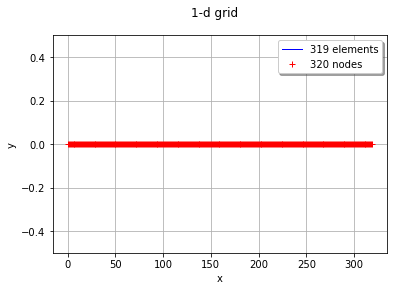

In [6]:
# I could add the step corresponding to ms, it is just a transformation
from openturns.viewer import View
aGraph = time_grid.draw1D() # Create a graph
aGraph.setTitle('1-d grid')
View(aGraph).show() # Draw the mesh

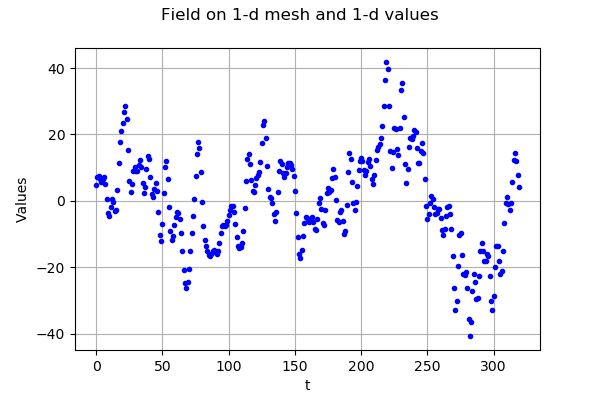

In [7]:
graph = field.draw()
graph.setTitle('Field on 1-d mesh and 1-d values')
graph

### <font color='green'> Etape 1: KarhunenLoeve </font>

In [6]:
s = 0.0 # 10e-2,  0.0 (6e-9->318) (5e-9->319)
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample, s) #0.0 (=s) correspond au threshold sur les valeurs propres
# s - The threshold used to select the most significant eigenmodes, defined in KarhunenLoeveAlgorithm.
# Essentially s = 0.0  selescts all the eigenmodes
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

In [ ]:
# Understand what are these:
# fPCA.getModes() : base fonctionelle (phi)
# fPCA.getEigenValues() : valeurs propres (lambda)
# Xi : résultat de la projection du processus sur cette base fonctionnelle (xi)

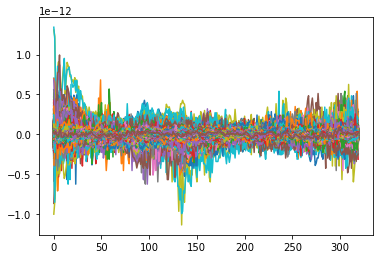

In [9]:
T     = np.array([t for t in time_grid.getValues()]).reshape(-1,1)
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()):
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [ ]:
modes = fPCA.getModes() # enables to get the associated modes, i.e base fonctionelle (phi)

In [ ]:
fPCA.getEigenValues() # valeurs propres (lambda)

### <font color='green'> Etape 2: PCA - erreur de troncature</font>

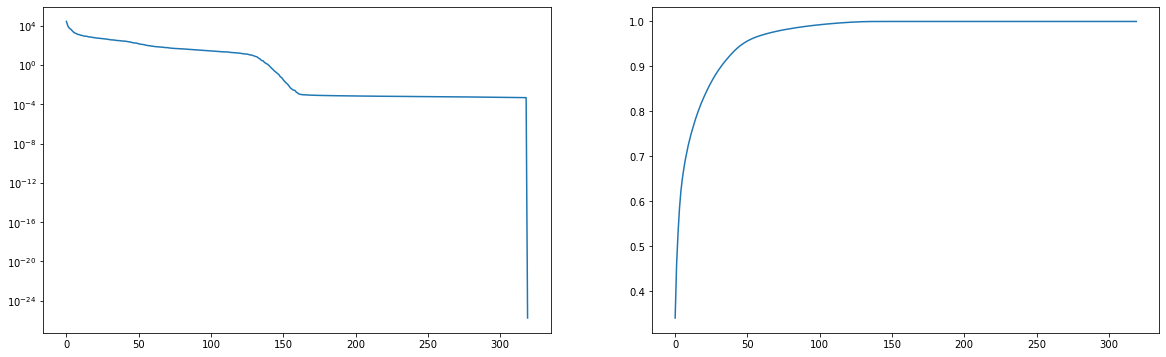

In [7]:
vp      = fPCA.getEigenValues() #  getEigenValues method enables to obtain the K first eigenvalues of the Karhunen Loeve decomposition
pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].semilogy(vp)
ax[1].plot (pVar)

## <font color='blue'> La détection d'anomalies </font>

In [8]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)

[1476, 3305, 5488, 8499, 12039, 12275, 12924]


In [11]:
Xi

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=13216 dimension=320 data=[[-0.401376,0.210053,0.269109,...,-1.41095,-0.252921,0.125],[-0.0817485,-0.226689,-0.0525533,...,1.55096,-0.4135,0.242188],[-0.324008,0.362636,0.301947,...,-1.03164,1.63429,0],...,[0.402109,-0.736437,1.26848,...,1.38728,-1.09313,-0.09375],[0.570729,-0.771931,1.19532,...,-0.526688,0.404594,0.3125],[0.206409,-0.638064,1.14863,...,1.49194,-0.743074,-0.212891]]

### <font color='green'> Minimum Level Set </font>

On prend 2 modes (c'est plus facile pour visualiser), et on cherche la ligne de niveau qui minimise la surface sur le plan $\xi [0]$ x $\xi [1]$.

Ensuite on peut tester sur pour un signal donné, sa projection sur les 2 axes principaux est à l'intérieur ou à l'extérieur de cette surface.

 Nb Outlier =  0


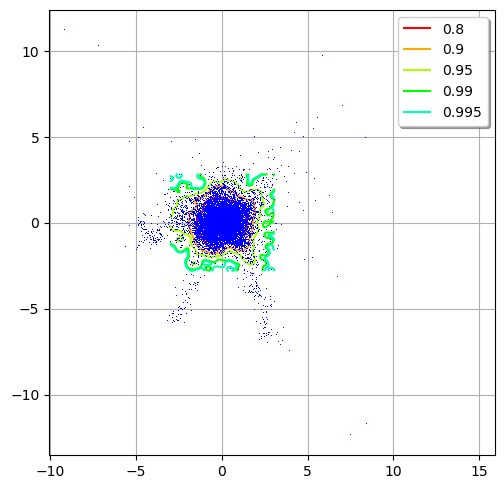

In [12]:
import openturns.viewer as otv 

#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

In [ ]:
# Extract for each segment its proyection in k modes, for varying k

In [ ]:
# Am I collapsing the time? If so, is this desirible? .. I can take the modes and proyect back to my entire space

In [ ]:
# Plot number of modes vs performance

## <font color='blue'> Export data </font>

In [14]:
import os
nModes = 320
nChannels = 59
path_data_save = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/nModes'+ str(nModes)))

for event_index in range(Xi.getSize()//59):
    x = Xi[0*nChannels:0*nChannels+nChannels][:,0:nModes]
    A = np.asarray(x)
    path_out = os.path.join(path_data_save, '%s_segment_%d_event.npy' % (test_id, int(eeg_events_index[event_index])))
    np.save(path_out, A)

## <font color='blue'> Non-events </font>

In [55]:
# DO not run
import os
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/Balanced_01'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))

df_eeg = pd.DataFrame([])
labels = []
for num, file in enumerate(files): # create a pandas df with 
    label = {'event': 1.0, 'noevent': 0.0}[file.split('_')[-1].split('.')[0]]
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    #df_interval.insert(0, "event", label, True) 
    outliers = np.unique(np.where(np.asarray(df_interval)>2000)[0])
    if len(outliers) == 0:
        df_eeg = df_eeg.append(df_interval)
        labels.append(label)
    else:
        print(num)
df_eeg.to_csv(r'df_eeg_balanced.csv', index = False)
print(df_eeg.shape)

165
354
(27022, 320)


In [57]:
len(labels)

458

In [59]:
test_id = "VPja.mat" # Not used here
df_eeg_file = 'df_eeg_balanced.csv' # Corresponds to VPja
#Lecture
df_eeg = pd.read_csv( df_eeg_file )
n_channels = 59
split   = df_eeg.shape[1] 
nSample = df_eeg.shape[0]
#Traitement  
NPeeg = np.asarray(df_eeg)
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
mu_t    = NPeegC.mean(axis=0) # Pour avoir des processus centrés

In [60]:
for k in range(process_sample.getSize()):
    field.setValues(NPeegC[k:k+1,:].T - mu_t.reshape(-1,1))
    process_sample[k] = field

In [61]:
process_sample = ot.ProcessSample(time_grid, nSample, dim_ch) 
field          = ot.Field(time_grid, dim_ch)                     #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    field.setValues(NPeegC[k:k+dim_ch,:].T - mu_t.reshape(-1,1))
    process_sample[k] = field
Xi  = fPCA.project(process_sample)

In [ ]:
T     = np.array([t for t in time_grid.getValues()]).reshape(-1,1)
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()):
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [62]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)
print(len(Anomalies))

[4662, 6727, 11329, 11683, 17228, 17229, 17408, 18175, 18183, 18193, 21005, 24724, 25196, 26494]
14


 Nb Outlier =  585


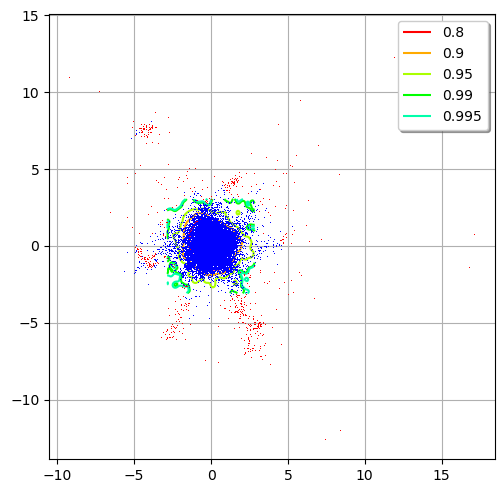

In [176]:
import openturns.viewer as otv 
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
X      = Xi.getMarginal ([1,3])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)


cloud2 = ot.Cloud(Xout)
cloud2.setPointStyle('dot')
cloud2.setColor('red')
graph.add(cloud2)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

In [63]:
Xi

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=27022 dimension=320 data=[[-0.455923,-0.0766214,0.349875,...,-1.40925,-0.282988,0.0625],[-0.136295,-0.513363,0.0282123,...,1.55266,-0.443567,0.238281],[-0.378554,0.0759619,0.382712,...,-1.02994,1.60423,0.03125],...,[0.347563,-1.02311,1.34925,...,1.38898,-1.1232,-0.15625],[0.516183,-1.05861,1.27609,...,-0.524989,0.374527,0.25],[0.151863,-0.924738,1.2294,...,1.49364,-0.773141,-0.183594]]

In [153]:
n_channels = 59
kmeans_labels = np.empty((0,458 ))
for j in range(Xi_np.shape[1]):
    X = np.empty((0,n_channels ))
    for i in range(int(len(Xi_np)/n_channels)):
        brr = Xi_np[i*n_channels:(i+1)*n_channels,j]
        X = np.append(X, [brr], axis=0)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    kmeans_label = np.squeeze(kmeans.labels_)
    kmeans_labels = np.append(kmeans_labels, [kmeans_label], axis=0)

end


In [168]:
kmeans_labels.shape

(320, 458)

In [164]:
r = np.zeros((Xi_np.shape[1],1))
for i in range(Xi_np.shape[1]):
    r[i] = np.corrcoef(kmeans_labels[i,:], labels)[0,1]

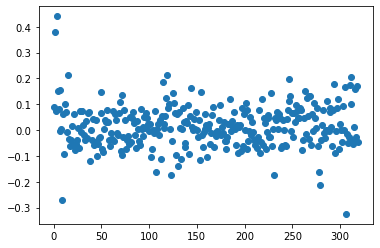

In [165]:
plt.plot(r, linestyle = "", marker="o")